### Maxwell's equation for the magnetic field strength. 
Values for variation: E from 300 to 3000 step 10, sigma from 0.1 to 1.0 step 0.1, H_R = 5000, tube radius R=0.012m.

Predict H(0) by linear regression. We evaluate the quality of the model.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from joblib import dump, load

In [2]:
class Plasmatron():
    
    '''Setting model parameters and the solution of the equation'''
    
    def __init__(self, H_R=5000, R=0.012, N=200, h=0.0000038):
        '''Parameter initialization'''
        self.H_R = H_R
        self.R = R
        self.N = N
        self.h = h

        self.sigma_start = 0.1
        self.sigma_end = 1.01
        self.sigma_step = 0.1

        self.E_start = 300
        self.E_end = 3001
        self.E_step = 10
        
        self.sigma = np.array([round(i, 1) for i in np.arange(self.sigma_start, self.sigma_end, self.sigma_step)])
        self.E = np.array(range(self.E_start, self.E_end, self.E_step))
    
    def sweep(self, sigma, N, R, h, E, H_R):
        '''Equation solution'''
        A = np.zeros(N)
        B = np.zeros(N)
        C = np.zeros(N)
        F = np.zeros(N)

        r = np.linspace(h, R, N)
        V = 1 / sigma

        for i in range(0, N):
            r_imh = r[i] - h / 2
            r_iph = r[i] + h / 2
            V_imh = (V)
            V_iph = (V)
            f_i = 2 * sigma * E ** 2
            A[i] = r[i] * V_iph
            B[i] = r_iph * V_iph
            C[i] = r_imh * V_imh + B[i]
            F[i] = -r[i] * f_i * h ** 2

        H     = np.zeros(N)
        alpha = np.zeros(N)
        beta  = np.zeros(N)

        beta[N - 1] = H_R

        for i in reversed(range(0, N - 1)):
            alpha[i] = A[i] / (C[i] - B[i] * alpha[i + 1])
            beta[i] = (B[i] * beta[i + 1] + F[i]) / (C[i] - B[i] * alpha[i + 1])

        H[0] = (beta[0] - alpha[0] * beta[1]) / (1 - alpha[0] * alpha[1])

        for i in range(1, N - 1):
            H[i + 1] = alpha[i + 1] * H[i] + beta[i + 1]
        return H, r
    
    def Computingdata(self):
        '''Computing'''
        
        self.filename = 'data.xlsx' 
        self.file_path = os.path.join(os.getcwd(), self.filename)
        
        if os.path.exists(self.file_path):
            df = pd.read_excel(self.file_path)
        else:
            df = pd.DataFrame(columns=['H', 'R', 'E', 'sigma'])

            sigma = self.sigma
            H_R = self.H_R
            E = self.E
            N = self.N
            R = self.R
            h = self.h

            H_list = []
            R_list = []
            E_list = []
            sigma_list = []

            for s in sigma:
                for e in E:
                    for i in range(1, N):
                        H, r = self.sweep(s, N, R, h, e, H_R)
                        H_list.append(H[i])
                        R_list.append(r[i])
                        E_list.append(e)
                        sigma_list.append(s)

            H_list = H_list/max(H_list)
            R_list = R_list/max(R_list)
            E_list = E_list/max(E_list)
            sigma_list = sigma_list/max(sigma_list)

            df = pd.DataFrame({'H': H_list, 'R': R_list, 'E': E_list, 'sigma': sigma_list})
            df = df.loc[df['H'] > 0]
            df.to_excel('data.xlsx', index=False)
        
        return df

In [3]:
class DataExploration():
    '''Graphs. Relationships between features'''
    def __init__(self, df):
        self.df = df
        
    def charts(self):
        sns.pairplot(df,diag_kind='kde')

In [12]:
class LRModel():
    '''Initializing the Linear Regression Model'''
    def __init__(self, df):
        self.df = df
        
        self.X = df.drop('H',axis=1)
        self.y = df['H']
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=101)
        
    def usual(self):
                        
        model = LinearRegression()
        model.fit(self.X_train, self.y_train)
        
        test_predictions = model.predict(self.X_test)
        
        MAE = mean_absolute_error(self.y_test, test_predictions)
        MSE = mean_squared_error(self.y_test, test_predictions)
        RMSE = np.sqrt(MSE)

        print('Metrics usual model ','MAE :', MAE, 'MSE :', MSE, 'RMSE :', RMSE)
        
        filename = 'usual_model.joblib' 
        file_path = os.path.join(os.getcwd(), filename)
        
        if os.path.exists(file_path):
            usual_model = load('usual_model.joblib')
        else:
            usual_model = LinearRegression()
            usual_model.fit(self.X,self.y)
            dump(usual_model, 'usual_model.joblib') 
        
        coeff_df = pd.DataFrame(usual_model.coef_,self.X.columns,columns=['Coefficient'])

        return usual_model
        
        
    def polynom(self):
        
        train_rmse_errors = []
        test_rmse_errors = []

        for d in range(1,10):

            polynomial_converter = PolynomialFeatures(degree=d,include_bias=False)
            poly_features = polynomial_converter.fit_transform(self.X)

            X_train, X_test, y_train, y_test = train_test_split(poly_features, self.y, test_size=0.3, random_state=101)

            model = LinearRegression(fit_intercept=True)
            model.fit(X_train,y_train)

            train_pred = model.predict(X_train)
            test_pred = model.predict(X_test)

            train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred))
            test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred))

            train_rmse_errors.append(train_RMSE)
            test_rmse_errors.append(test_RMSE)
            
            print('Metrics polynom = ' + str(d) + ' model ','train_RMSE :', train_RMSE, 'test_RMSE :', test_RMSE)
            
        plt.plot(range(1,10),train_rmse_errors,label='TRAIN')
        plt.plot(range(1,10),test_rmse_errors,label='TEST')
        plt.xlabel("Polynomial Complexity")
        plt.ylabel("RMSE")
        plt.legend()
        plt.show()
        
        filename = 'poly_model.joblib' 
        file_path = os.path.join(os.getcwd(), filename)
        
        if os.path.exists(file_path):
            
            final_poly_converter = load('poly_converter.joblib')
            final_model = load('poly_model.joblib')
            
        else:
        
            final_poly_converter = PolynomialFeatures(degree=3,include_bias=False)
            final_model = LinearRegression()
            final_model.fit(final_poly_converter.fit_transform(self.X),self.y)

            dump(final_model, 'poly_model.joblib') 
            dump(final_poly_converter,'poly_converter.joblib')
        
        return final_model, final_poly_converter        

In [5]:
Plasma_model = Plasmatron()

In [6]:
df = Plasma_model.Computingdata()

In [16]:
df.head()

,H,R,E,sigma
0,0.010904,0.608164,0.1,0.1
1,0.026796,0.613188,0.1,0.1
2,0.042677,0.618211,0.1,0.1
3,0.058542,0.623235,0.1,0.1
4,0.074389,0.628258,0.1,0.1


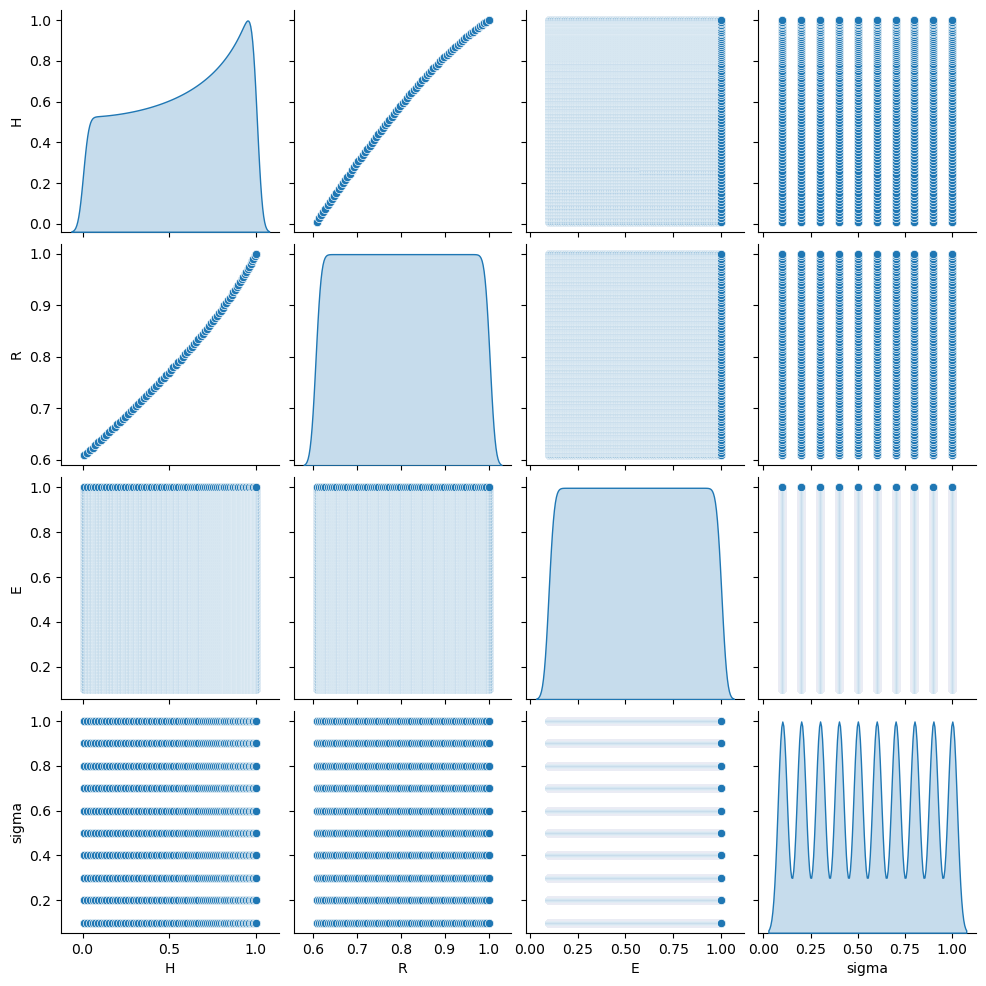

In [7]:
DataExploration.charts(df)

In [14]:
# Regular model sklearn
LR = LRModel(df)
model = LR.usual()
# signs = [[1,2,3]]
# model.predict(signs)

Metrics usual model  MAE : 0.022949896005962936 MSE : 0.000709170457150192 RMSE : 0.026630254545351083


Metrics polynom = 1 model  train_RMSE : 0.026627097017832866 test_RMSE : 0.02663025454535069
Metrics polynom = 2 model  train_RMSE : 0.0029194219311113536 test_RMSE : 0.0029207327203035036
Metrics polynom = 3 model  train_RMSE : 0.00036162177241201424 test_RMSE : 0.0003614702856965416
Metrics polynom = 4 model  train_RMSE : 1.6031696034261443e-05 test_RMSE : 1.6022733041868874e-05
Metrics polynom = 5 model  train_RMSE : 4.058044356646781e-07 test_RMSE : 4.071557630453857e-07
Metrics polynom = 6 model  train_RMSE : 8.419138959867331e-09 test_RMSE : 8.468655105770876e-09
Metrics polynom = 7 model  train_RMSE : 5.454265936030024e-10 test_RMSE : 5.456085031861092e-10
Metrics polynom = 8 model  train_RMSE : 2.637610623281716e-11 test_RMSE : 2.6607284301653752e-11
Metrics polynom = 9 model  train_RMSE : 1.1997631179393698e-11 test_RMSE : 1.1994449317397688e-11


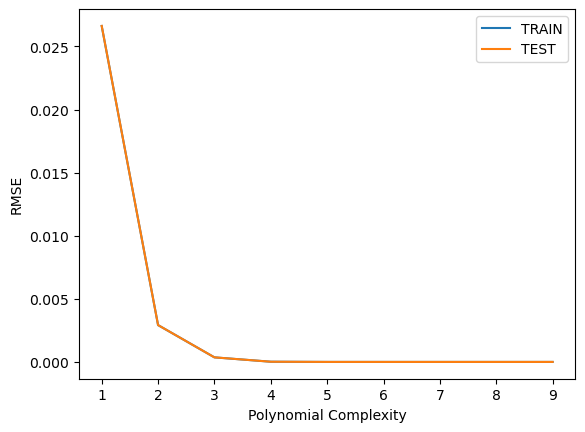

In [15]:
# Polynomial Regression
LR = LRModel(df)
model, loaded_poly = LR.polynom()
# signs = [[1,2,3]]
# signs_poly = loaded_poly.transform(signs)
# model.predict(signs_poly)